# Retrain CNN using manually labelled data
Learnings from last round:
- infrared labelling wasn't the best to train CNN .. it was confusing visually and not taking full advantage of what can be seen (different approach might be using three lines)
- The data set needs to be balanced (even though SlowForward will be dominant, it shouldn't be in training data, it will also make the accuracy meaning muddy)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import time

import matplotlib.pyplot as plt

import math
import json

#import ML liberaries
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Get the data from CSV file
data = pd.read_csv('labelled_images_04.01.2023.csv')

## 1. Visually Explore training data
Complete in previous stage upon data labelling

## 2. Prepare Data for Model Training

### 2.1 Create a balanced dataset

In [11]:
# show if the training data is not balanced
data['label txt'].value_counts()

SlowForward    1004
SoftRight       545
SoftLeft        384
Stop            215
Name: label txt, dtype: int64

In [5]:
# randomise dataset
rand_data = data.sample(frac=1, random_state=42)  # frac=1 means all rows, random_state for reproducibility

In [12]:
soft_left = rand_data[rand_data['label txt']=='SoftLeft']
stop = rand_data[rand_data['label txt']=='Stop']
slow_forward = rand_data[rand_data['label txt']=='SlowForward'].head(400)
soft_right = rand_data[rand_data['label txt']=='SoftRight'].head(400)

data = pd.concat([soft_left, stop, slow_forward,soft_right ])

In [20]:
# randomise the images order
data = data.sample(frac=1, random_state=42)
data = data.reset_index()

In [28]:
data.head(3)

,index,img,labels,label txt
0,1271,"[[96, 101, 102, 104, 109, 109, 114, 115, 114, ...",1,SlowForward
1,1937,"[[113, 115, 121, 126, 130, 125, 135, 144, 125,...",1,SlowForward
2,1506,"[[78, 76, 79, 85, 90, 91, 95, 95, 93, 92, 96, ...",2,SoftLeft


In [29]:
# organise data in the right format for model training
X = []
Y = []

for i in range(len(data)):
    # get the image by location (as json format)
    img_as_json = data['img'][i]
    # convert the json to nested list
    img_as_list = json.loads(img_as_json)
    motion = data['labels'][i]
    X.append(img_as_list)
    Y.append(motion)

In [30]:
# Convert the nested lists to np.array lists (the format required by Tensorflow to train model)
X = np.array(X)
Y = np.array(Y)

# Normalise the image data
X = X/ 255.0

In [31]:
# Run a few checks to confirm data type and structure
type(X), X.dtype, X.shape

(numpy.ndarray, dtype('float64'), (1399, 30, 54))

In [32]:
# Split data for training & testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 3. Train & Evaluate ML model

inspiration: source: https://github.com/nicknochnack/ImageClassification/blob/main/Getting%20Started.ipynb

In [33]:
# initiate model
model = Sequential()

# build model
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(30,54,1))) # (hight, width, color)
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu')) 
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

# Compile model
model.compile('adam', loss=SparseCategoricalCrossentropy(from_logits=True) , metrics=['accuracy'])  #  #'categorical_crossentropy'

# Show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 52, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 26, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 12, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 10, 16)         4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 5, 16)         0

In [34]:
# Define a TensorBoard callback during model training
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

hist = model.fit(X_train, Y_train, epochs=20,validation_data= (X_test, Y_test), callbacks=[tensorboard_callback])

Epoch 1/20


c:\Users\peter\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 [==============================] - 2s 42ms/step - loss: 1.2654 - accuracy: 0.4960 - val_loss: 1.0594 - val_accuracy: 0.6321
Epoch 2/20
35/35 [==============================] - 1s 25ms/step - loss: 0.6532 - accuracy: 0.7837 - val_loss: 0.6185 - val_accuracy: 0.7893
Epoch 3/20
35/35 [==============================] - 1s 24ms/step - loss: 0.4479 - accuracy: 0.8490 - val_loss: 0.4868 - val_accuracy: 0.8321
Epoch 4/20
35/35 [==============================] - 1s 24ms/step - loss: 0.3472 - accuracy: 0.8749 - val_loss: 0.4573 - val_accuracy: 0.8321
Epoch 5/20
35/35 [==============================] - 1s 26ms/step - loss: 0.3093 - accuracy: 0.8901 - val_loss: 0.3558 - val_accuracy: 0.8821
Epoch 6/20
35/35 [==============================] - 1s 25ms/step - loss: 0.2854 - accuracy: 0.8963 - val_loss: 0.3450 - val_accuracy: 0.8857
Epoch 7/20
35/35 [==============================] - 1s 24ms/step - loss: 0.2518 - accuracy: 0.9142 - val_loss: 0.3233 - val_accuracy: 0.8929
Epoch 8/20
35/35 [======

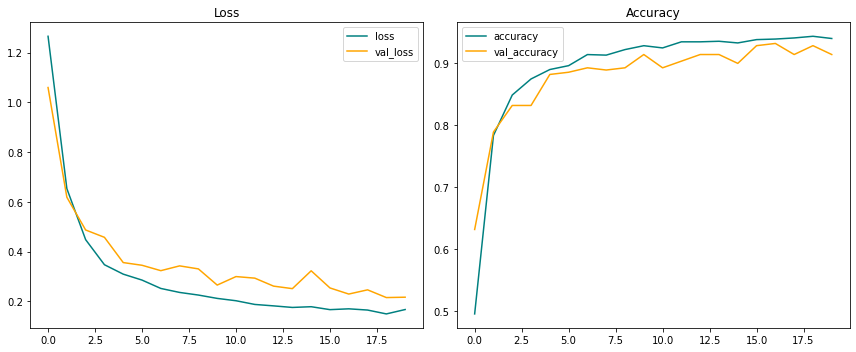

In [35]:
# Create a figure and two subplots side by side for Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Loss subplot
axes[0].plot(hist.history['loss'], color='teal', label='loss')
axes[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axes[0].set_title('Loss')
axes[0].legend(loc="upper right")

# Plot Accuracy subplot
axes[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axes[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axes[1].set_title('Accuracy')
axes[1].legend(loc="upper left")

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

In [36]:
# Assess model performance on test set -we'll use this to compare performance against Tensorflow lite model later
test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)
print('\nTest accuracy is {}%'.format(round(100*test_acc, 2)))

9/9 - 0s - loss: 0.2166 - accuracy: 0.9143 - 98ms/epoch - 11ms/step

Test accuracy is 91.43%


## 4. Test some examples

In [37]:
def review_model_predictions(data = data, label_txt = ['Stop', 'SlowForward', 'SoftLeft', 'SoftRight'], START_FRAME = 200, END_FRAME = 300 ):
    no_of_frames = END_FRAME - START_FRAME
    # import math
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(22, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the json to np.array
        img_as_list = json.loads(img_as_json)
        img_as_array = np.array(img_as_list)

        # get model prediction and convert it to txt
        model_prediction = model.predict(np.expand_dims(img_as_array/255, 0))
        model_prediction = label_txt[np.argmax(model_prediction)]

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['label txt'][i]} , Model: {model_prediction} ") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 25ms/step


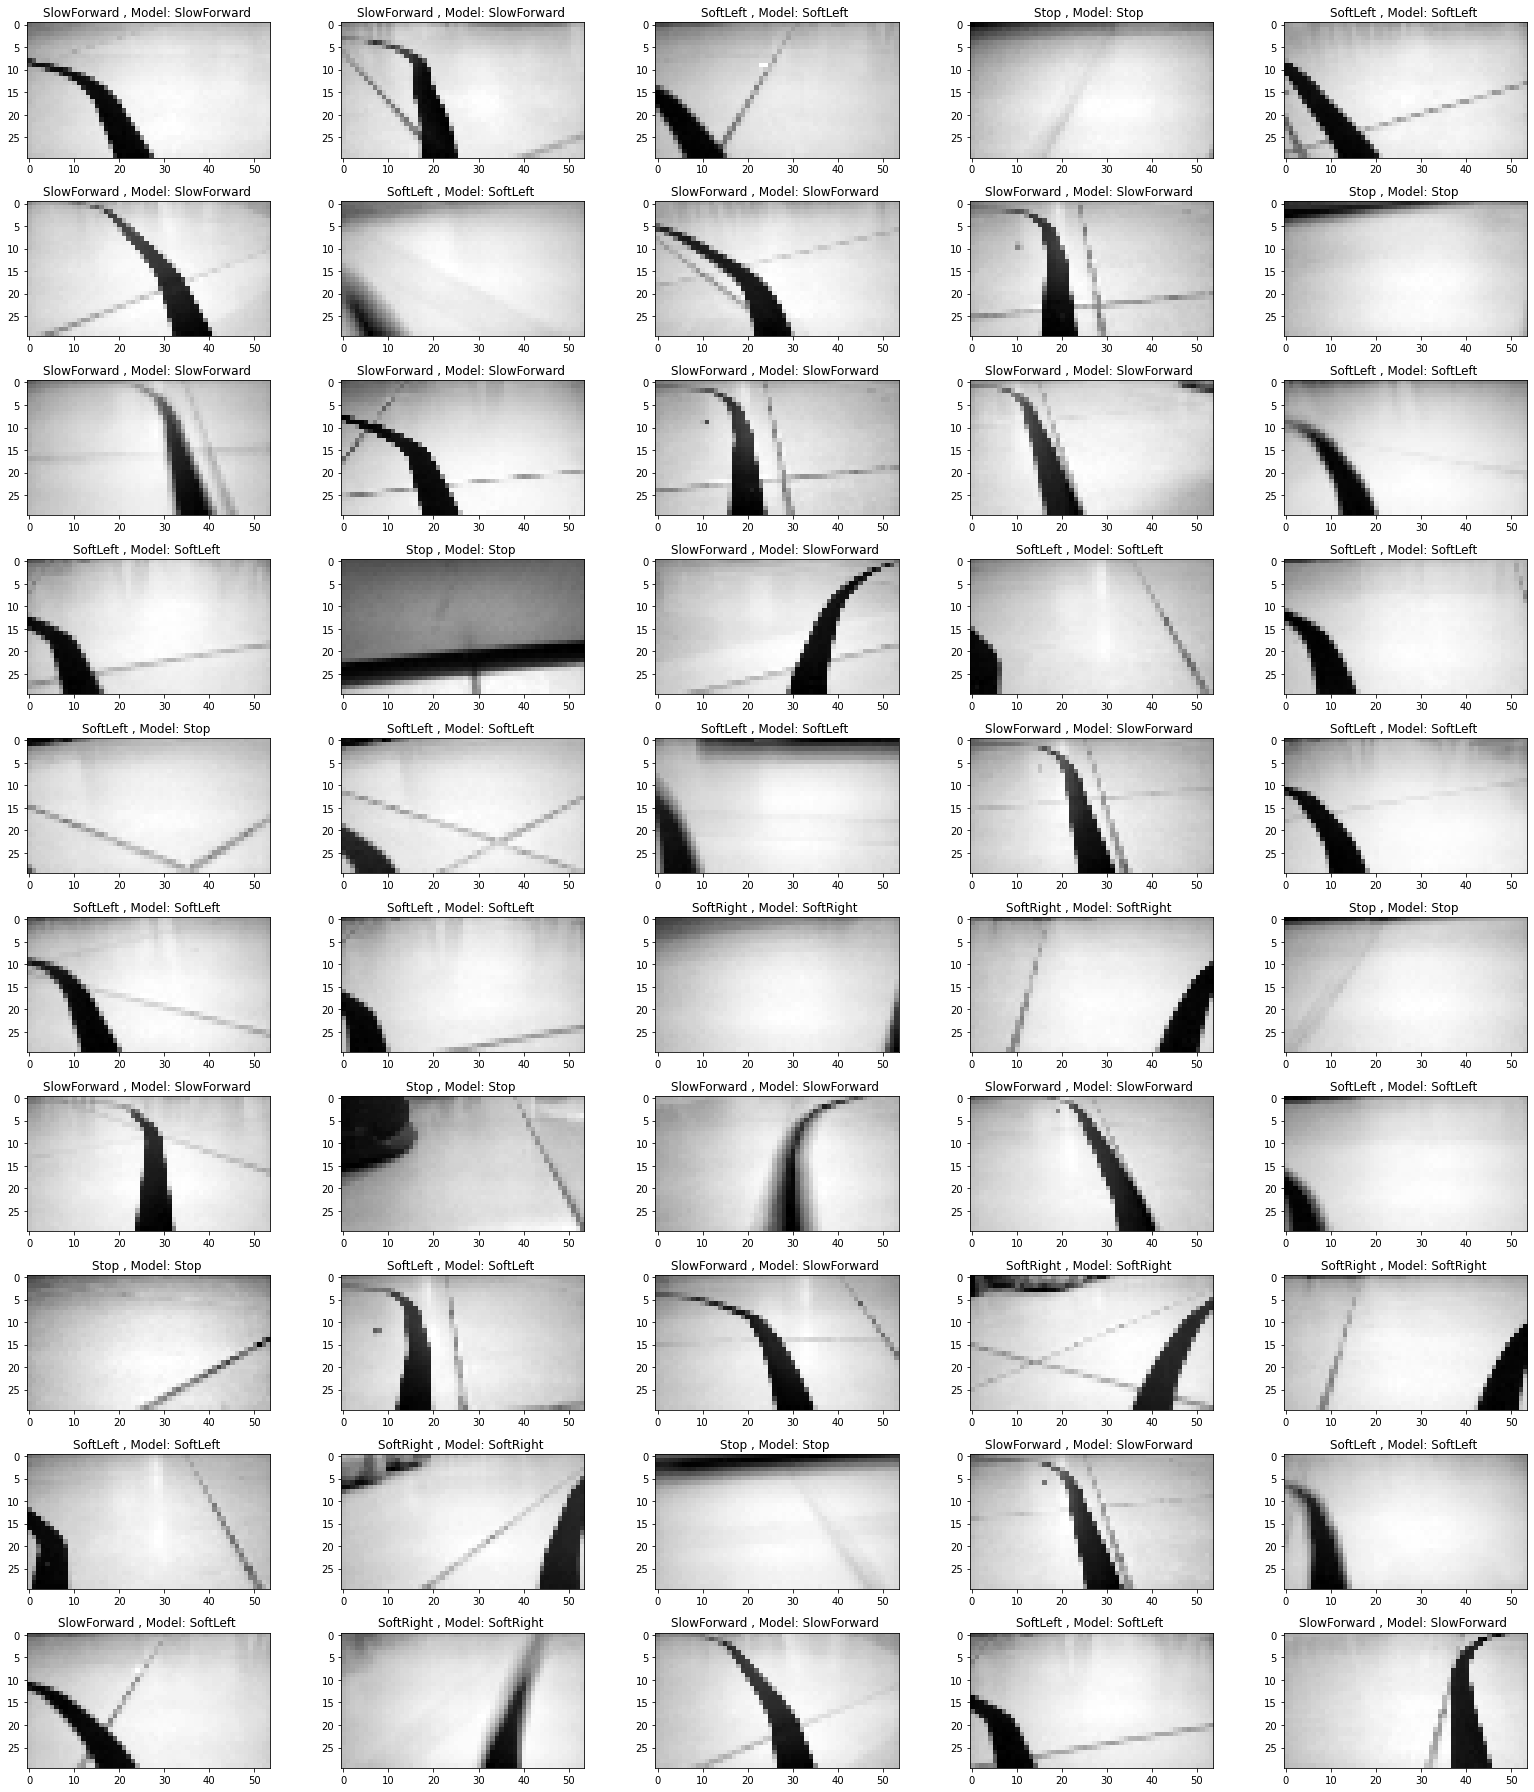

In [38]:
review_model_predictions(data = data,  
                         label_txt = ['Stop', 'SlowForward', 'SoftLeft', 'SoftRight'],
                         START_FRAME = 0, 
                         END_FRAME = 50 )

## 5. Save the model

In [39]:
model.save('computer_vision_driver_v2.h5')

## 6. Create & Evaluate TensorFlow Lite model
https://colab.research.google.com/drive/1MTMWpavykGkzG_5TeRW4lKKdocNBj9To

In [40]:
from tensorflow.keras.models import load_model

# load TF model
new_model = load_model('computer_vision_driver_v2.h5')

In [41]:
# Convert the Keras model to tflite model
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\peter\AppData\Local\Temp\tmp8u9zia96\assets


INFO:tensorflow:Assets written to: C:\Users\peter\AppData\Local\Temp\tmp8u9zia96\assets


In [42]:
# name and save the lite model 
tflite_model_name = "computer_vision_driver_v2.tflite"
open(tflite_model_name, "wb").write(tflite_model)

126296

In [43]:
# Check input Tensor shape

interpreter = tf.lite.Interpreter(model_path = tflite_model_name)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [ 1 30 54  1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 4]
Output Type: <class 'numpy.float32'>


In [44]:
# Resize input tensor - to allow for bulk test data predictions
interpreter.resize_tensor_input(input_details[0]['index'], (len(X_test), 30, 54, 1))
interpreter.resize_tensor_input(output_details[0]['index'], (len(Y_test), 4))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [280  30  54   1]
Input Type: <class 'numpy.float32'>
Output Shape: [280   4]
Output Type: <class 'numpy.float32'>


In [45]:
# Change X_test data type and shape to match tensor floe expectations
X_test = np.array(X_test, dtype=np.float32)
X_test = X_test.reshape(X_test.shape[0], 30, 54, 1)

In [46]:
interpreter.set_tensor(input_details[0]['index'], X_test)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Prediction results shape: (280, 4)


In [47]:
acc = accuracy_score(prediction_classes, Y_test)
print('Test accuracy TFLITE Quantized model is {}%'.format(round(100*acc, 2)))

Test accuracy TFLITE Quantized model is 91.43%


Learnings:  The smaller model accuracy didn't change much from the original model!

## 7. Load and use TFLite model

In [48]:
def review_lite_model_predictions(data = data, model_path = 'computer_vision_driver_v2.tflite',label_txt = ['Stop', 'SlowForward', 'SoftLeft', 'SoftRight'], START_FRAME = 200, END_FRAME = 300 ):
    
    # Establish the gragh parameters
    no_of_frames = END_FRAME - START_FRAME
    nrows = math.ceil(no_of_frames/5)
    ncols = 5

    fig, axs = plt.subplots(nrows, ncols, figsize=(22, nrows * 2.5))

    # Flattening the axs array to iterate through it
    axs = axs.flatten()

    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_shape = input_details[0]['shape'] # not doing anything but useful to match the shape to tensorflow expectations

    # iterate through data to create histograms
    for i, j in zip(range(START_FRAME,END_FRAME ), range(no_of_frames)):
        # get the image by location (as json format)
        img_as_json = data['img'][i]

        # convert the json to nested list
        img_as_list = json.loads(img_as_json)

        # convert the json to np.array
        img_as_list = json.loads(img_as_json)
        img_as_array = np.array(img_as_list, dtype=np.float32)/255  # TensorFlow lite convert dtype to Float32 instead of float64 to save space
        # Reshape the array to match Tensorflow expectations
        img_as_array = img_as_array.reshape(1, 30, 54, 1)

        # get model prediction and convert it to txt
        interpreter.set_tensor(input_details[0]['index'], img_as_array)
        interpreter.invoke()
        model_prediction = interpreter.get_tensor(output_details[0]['index'])
        model_prediction = label_txt[np.argmax(model_prediction)]

        # convert the nested list to np.array
        img = np.array(img_as_list)
        axs[j].imshow(img, cmap='gray')
        axs[j].set_title(f"{data['label txt'][i]} ,  Model: {model_prediction} ") # ,  {data['time-sec'][i]}

        # Hiding empty subplots if any
        for k in range(no_of_frames, len(axs)):
            axs[k].axis('off')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

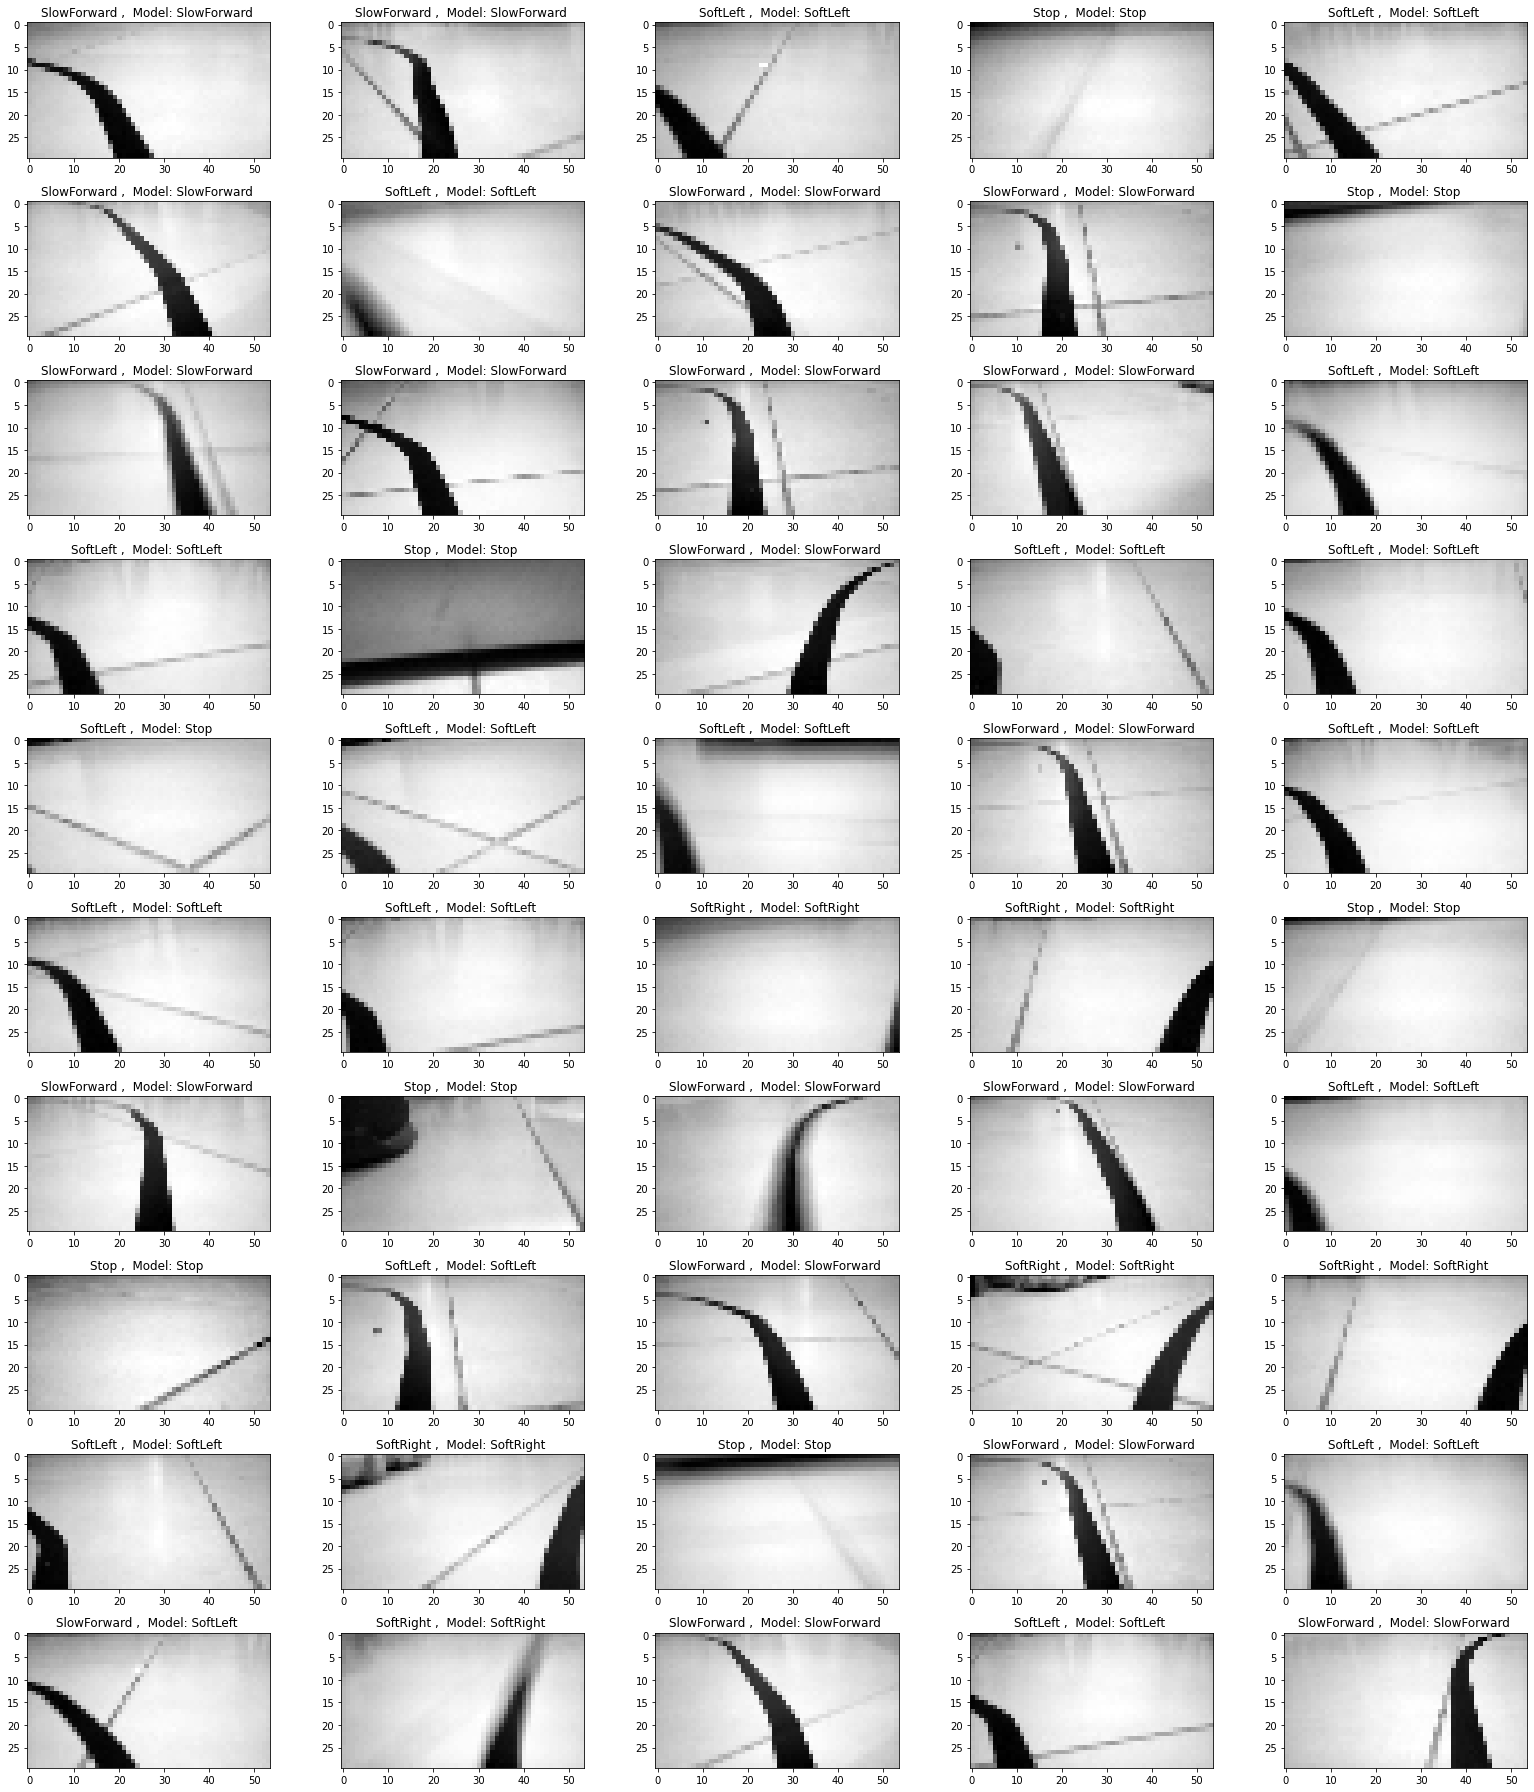

In [50]:
review_lite_model_predictions(data = data, 
                              model_path = 'computer_vision_driver_v2.tflite',
                              label_txt = ['Stop', 'SlowForward', 'SoftLeft', 'SoftRight'],
                              START_FRAME = 0, 
                              END_FRAME = 50 )